**Telephone Customer Churn Prediction - Harshit Jain | IIT Kanpur**

# **1. Introduction**

Customer Churn is when customers leave a service in a given period of time, what is bad for business.

This work has as objective to build a machine learning model to predict what customers will leave the service. 

Also, an Exploratory Data Analysis is made to a better understand about the data. 

Another point on this work is use the PyCaret Python Module to make all the experiment pipeline.

**1.1 Enviroment Setup**

In [ ]:
!pip install pycaret

In [2]:
# Standard
import pandas as pd
import numpy as np
# Pycaret
from pycaret.classification import *
# Plots
from plotly.offline import iplot
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import seaborn as sns
# Sklearn tools
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import *
# Extras
from datetime import date
import warnings
warnings.filterwarnings("ignore")
# Datapath and Setup
data_path = "/kaggle/input/telco-customer-churn/"
random_seed = 142

In [3]:
# Helper functions for structured data
## Get info about the dataset
def dataset_info(dataset, dataset_name: str):
    print(f"Dataset Name: {dataset_name} | Number of Samples: {dataset.shape[0]} | Number of Columns: {dataset.shape[1]}")
    print(30*"=")
    print("Column             Data Type")
    print(dataset.dtypes)
    print(30*"=")
    missing_data = dataset.isnull().sum()
    if sum(missing_data) > 0:
        print(missing_data[missing_data.values > 0])
    else:
        print("No Missing Data on this Dataset!")
    print(30*"=")
    print(f"Memory Usage: {np.round(dataset.memory_usage(index=True).sum() / 10e5, 3)} MB")
## Dataset Sampling
def data_sampling(dataset, frac: float, random_seed: int):
    data_sampled_a = dataset.sample(frac=frac, random_state=random_seed)
    data_sampled_b =  dataset.drop(data_sampled_a.index).reset_index(drop=True)
    data_sampled_a.reset_index(drop=True, inplace=True)
    return data_sampled_a, data_sampled_b   
## Bar Plot
def bar_plot(data, plot_title: str, x_axis: str, y_axis: str):
    colors = ["#0080ff",] * len(data)
    colors[0] = "#ff8000"
    trace = go.Bar(y=data.values, x=data.index, text=data.values, 
                    marker_color=colors)
    layout = go.Layout(autosize=False, height=600,
                    title={"text" : plot_title,
                       "y" : 0.9,
                       "x" : 0.5,
                       "xanchor" : "center",
                       "yanchor" : "top"},  
                    xaxis={"title" : x_axis},
                    yaxis={"title" : y_axis},)
    fig = go.Figure(data=trace, layout=layout)
    fig.update_layout(template="simple_white")
    fig.update_traces(textposition="outside",
                    textfont_size=14,
                    marker=dict(line=dict(color="#000000", width=2)))                
    fig.update_yaxes(automargin=True)
    iplot(fig)
## Plot Pie Chart
def pie_plot(data, plot_title: str):
    trace = go.Pie(labels=data.index, values=data.values)
    layout = go.Layout(autosize=False,
                    title={"text" : plot_title,
                       "y" : 0.9,
                       "x" : 0.5,
                       "xanchor" : "center",
                       "yanchor" : "top"})
    fig = go.Figure(data=trace, layout=layout)
    fig.update_traces(textfont_size=14,
                    marker=dict(line=dict(color="#000000", width=2)))
    fig.update_yaxes(automargin=True)            
    iplot(fig)
## Histogram
def histogram_plot(data, plot_title: str, y_axis: str):
    trace = go.Histogram(x=data)
    layout = go.Layout(autosize=False,
                    title={"text" : plot_title,
                       "y" : 0.9,
                       "x" : 0.5,
                       "xanchor" : "center",
                       "yanchor" : "top"},  
                    yaxis={"title" : y_axis})
    fig = go.Figure(data=trace, layout=layout)
    fig.update_traces(marker=dict(line=dict(color="#000000", width=2)))
    fig.update_layout(template="simple_white")
    fig.update_yaxes(automargin=True)
    iplot(fig)
# Particular case: Histogram subplot (1, 2)
def histogram_subplot(dataset_a, dataset_b, feature_a: str,
                        feature_b: str, title: str, title_a: str, title_b: str):
    fig = make_subplots(rows=1, cols=2, subplot_titles=(
                        title_a,
                        title_b
                        )
                    )
    fig.add_trace(go.Histogram(x=dataset_a[feature_a], showlegend=False), row=1, col=1)
    fig.add_trace(go.Histogram(x=dataset_b[feature_b], showlegend=False), row=1, col=2)
    fig.update_layout(template="simple_white")
    fig.update_layout(autosize=False,
                        title={"text" : title,
                        "y" : 0.9,
                        "x" : 0.5,
                        "xanchor" : "center",
                        "yanchor" : "top"},  
                        yaxis={"title" : "<i>Frequency</i>"})
    fig.update_traces(marker=dict(line=dict(color="#000000", width=2)))
    fig.update_yaxes(automargin=True)
    iplot(fig)
# Calculate scores with Test/Unseen labeled data
def test_score_report(data_unseen, predict_unseen):
    le = LabelEncoder()
    data_unseen["Label"] = le.fit_transform(data_unseen.Churn.values)
    data_unseen["Label"] = data_unseen["Label"].astype(int)
    accuracy = accuracy_score(data_unseen["Label"], predict_unseen["Label"])
    roc_auc = roc_auc_score(data_unseen["Label"], predict_unseen["Label"])
    precision = precision_score(data_unseen["Label"], predict_unseen["Label"])
    recall = recall_score(data_unseen["Label"], predict_unseen["Label"])
    f1 = f1_score(data_unseen["Label"], predict_unseen["Label"])

    df_unseen = pd.DataFrame({
        "Accuracy" : [accuracy],
        "AUC" : [roc_auc],
        "Recall" : [recall],
        "Precision" : [precision],
        "F1 Score" : [f1]
    })
    return df_unseen
# Confusion Matrix
def conf_mat(data_unseen, predict_unseen):
    unique_label = data_unseen["Label"].unique()
    cmtx = pd.DataFrame(
        confusion_matrix(data_unseen["Label"], predict_unseen["Label"], labels=unique_label), 
        index=['{:}'.format(x) for x in unique_label], 
        columns=['{:}'.format(x) for x in unique_label]
    )
    ax = sns.heatmap(cmtx, annot=True, fmt="d", cmap="YlGnBu")
    ax.set_ylabel('Predicted')
    ax.set_xlabel('Target');
    ax.set_title("Predict Unseen Confusion Matrix", size=14);

# **2. Load Data**

In [5]:
dataset = pd.read_csv("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")
dataset.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


**Check for duplicated samples.**

In [6]:

dataset[dataset.duplicated()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


In [7]:
dataset_info(dataset, "customers")

Dataset Name: customers | Number of Samples: 7043 | Number of Columns: 21
Column             Data Type
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object
No Missing Data on this Dataset!
Memory Usage: 1.183 MB


The dataset has a small memory size allocation (1.183 MB) and is composed for many Categorical (object) features and only a few numeric, but one of the categorical features doesn't look right, the TotalCharges, as showed on the displayed dataframe, the festure is numeric.

TotalCharges is converted from Object to float64, the same of MonthlyCharges feature.

In [8]:
dataset["TotalCharges"] = pd.to_numeric(dataset["TotalCharges"], errors="coerce")
print(f"The Feature TotalCharges is type {dataset.TotalCharges.dtype} now!")

The Feature TotalCharges is type float64 now!


# **3. Exploratory Data Analysis**

**3.1 Churn Distribution**

The Client Churn Distribution is checked for any imbalance, as the feature is the target, it's important to choose what strategy to adopt when dealing with imbalanced classes.
Below, a Pie Chart shows the feature distribution.

In [9]:
pie_plot(dataset["Churn"].value_counts(), plot_title="<b>Client Churn Distribution<b>")

There's some imbalance on Churn Distribution, 26.5% of the clients have churned, and small occurences of a label could lead to bad predictor.
It's possible to choose some ways to work with this case:

* Make a random over-sampling, duplicating some samples of the minority class until this reach a balance, but this could lead to an overfitted model.

* Make a random down-sampling, removing some samples from the majority class until this reach a balance, but this leads to information loss and not feeding the model with the collected samples.

* Another resampling technique, as SMOTE.

* Choosing a metric that deals with imbalanced datasets, like F1 Score.

The Churn problem is about client retention, so is worth to check about false positives, so precision and recall metrics are a must for this situtation.

F1 Score is used to check the quality of the model predictions, as the metric is an harmonic mean of precision and recall.

**3.2 Analysis of the Contract Type**

In [10]:
df_aux = dataset.query('Churn == "No"')
df_aux = df_aux["Contract"].value_counts()
bar_plot(df_aux, "<b>Contract Types of not Churned Clients</b>", "<i>Contract</i>", "<i>Count</i>")

In [11]:
df_aux = dataset.query('Churn == "Yes"')
df_aux = df_aux["Contract"].value_counts()
bar_plot(df_aux, "<b>Contract Types of Churned Clients</b>", "<i>Contract</i>", "<i>Count</i>")

Now, the difference between a Month-to-month and annual contractts is bigger, and can lead to a conclusion that annual contracts are better to retain the clients, perhaps fidelity promotions could aid to reduce the churn rate.

As the problem can be examined more deep on Month-to-month contract types, a good idea is see the Monthly Charges and Total Charges distribution for the not churned clients of this contract

In [12]:
df_aux = dataset.query('(Contract == "Month-to-month") and (Churn == "No")')
histogram_subplot(df_aux, df_aux, "MonthlyCharges", "TotalCharges", "<b>Charges Distribution for Month-to-month contracts for not Churned Clients</b>",
                "(a) Monthtly Charges Distribution", "(b) Total Charges Distribution")

From the plots, can be said that many clients just got charged with a few values, principally for the Total Charges.
On the following plots, the same features are analyzed, but for churned clients.

In [13]:
df_aux = dataset.query('(Contract == "Month-to-month") and (Churn == "Yes")')
histogram_subplot(df_aux, df_aux, "MonthlyCharges", "TotalCharges", "<b>Charges Distribution for Month-to-month contracts for Churned Clients</b>",
                "(a) Monthtly Charges Distribution", "(b) Total Charges Distribution")

Total Charges had the same behaviour, but the Monthly Charges for many churned clients was high, maybe the amount of chage value could lead the client to leave the service.
Still on the Month-to-month contract, it's time to analyze the most used Payment methods of churned clients.



In [14]:
df_aux = dataset.query(('Contract == Month-to-month') and ('Churn == "Yes"'))
df_aux = df_aux["PaymentMethod"].value_counts()
bar_plot(df_aux, "<b>Payment Method of Month-to-month contract Churned Clients</b>", "<i>Payment Method</i>", "<i>Count</i>")

Many Churned Clients used to pay with electronic checks, automatic payments, as bank transfers or credit card have a few churned clients. A good idea could make promotions to clients that use automatic payment methods.
Lastly, the tenure of the churned clients.

In [15]:
df_aux = dataset.query(('Contract == Month-to-month') and ('Churn == "Yes"'))
df_aux = df_aux["tenure"].value_counts().head(5)
bar_plot(df_aux, "<b>Tenure of Month-to-month contract for Churned Clients</b>", "<i>Tenure</i>", "<i>Count</i>")

Most clients just used the service for one month, seems like the clients used to service to check the quality or the couldn't stay for the amount of charges, as the Monthly Charges for these clients was high and the Total Charges was small, as the client just stayed a little time

# **4. Setting up PyCaret**

Before setting up PyCaret, a random sample of 10% size of the dataset will be get to make predictions with unseen data.



In [16]:
data, data_unseen = data_sampling(dataset, 0.9, random_seed)
print(f"There are {data_unseen.shape[0]} samples for Unseen Data.")

There are 704 samples for Unseen Data.


The PyCaret's setup is made with 90% of data samples and just use one function (setup) from the module.

It's possible configure with variuos options, as data pre-processing, feature engineering, etc. The easy and efficient of PyCaret buy a lot of time when prototyping models.

Each setup is an experiment and for this problem, is used the following options:
* Normalization of the numerical features with Z-Score.
* Feature Selection with permutation importance techniques.
* Outliers Removal.
* Features Removal based on Multicollinearity.
* Features Scalling Transformation.
* Ignore low variance on Features.
* PCA for Dimensionality Reduction, as the dataset has many features.
* Numeric binning on the features MonthlyCharges and TotalCharges.
* 70% of samples for Train and 30% for test.


In [17]:
exp01 = setup(data=data, target="Churn", session_id=random_seed, ignore_features=["customerID"], 
                numeric_features=["SeniorCitizen"], normalize=True,
                feature_selection=True, remove_outliers=True, remove_multicollinearity=True,
                transformation=True, ignore_low_variance=True, pca=True, 
                bin_numeric_features=["MonthlyCharges", "TotalCharges"])

,Description,Value
0,session_id,142
1,Target,Churn
2,Target Type,Binary
3,Label Encoded,"No: 0, Yes: 1"
4,Original Data,"(6339, 21)"
5,Missing Values,True
6,Numeric Features,4
7,Categorical Features,15
8,Ordinal Features,False
9,High Cardinality Features,False


# **5. Model Build**

In [18]:
compare_models(fold=10, sort="F1")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
qda,Quadratic Discriminant Analysis,0.7573,0.8210,0.7025,0.5509,0.6172,0.4435,0.4508,0.028
lda,Linear Discriminant Analysis,0.7912,0.8352,0.5610,0.6456,0.5995,0.4594,0.4620,0.040
svm,SVM - Linear Kernel,0.7822,0.0000,0.5890,0.6191,0.5977,0.4499,0.4538,0.043
lr,Logistic Regression,0.7900,0.8405,0.5525,0.6452,0.5944,0.4540,0.4571,0.303
nb,Naive Bayes,0.7625,0.7827,0.5917,0.5721,0.5812,0.4157,0.4162,0.020
ridge,Ridge Classifier,0.7893,0.0000,0.5175,0.6554,0.5775,0.4399,0.4458,0.019
gbc,Gradient Boosting Classifier,0.7832,0.8313,0.5047,0.6424,0.5635,0.4224,0.4288,3.482
ada,Ada Boost Classifier,0.7725,0.8128,0.5012,0.6143,0.5504,0.4005,0.4052,0.803
lightgbm,Light Gradient Boosting Machine,0.7718,0.8129,0.4901,0.6141,0.5437,0.3944,0.3997,0.586
knn,K Neighbors Classifier,0.7523,0.7727,0.5260,0.5594,0.5414,0.3721,0.3730,0.230


QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)

The best model suggested by PyCaret is the Quadratic Discriminant Analysis (QDA), with a F1 Score around 0.6 and a good Recall, around 0.7.

In [19]:
base_alg = "qda"
base_model = create_model(base_alg)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7322,0.7947,0.7373,0.5148,0.6063,0.4130,0.4283
1,0.7464,0.8169,0.6610,0.5379,0.5932,0.4118,0.4164
2,0.7512,0.8228,0.6780,0.5442,0.6038,0.4256,0.4310
3,0.7607,0.8368,0.7094,0.5533,0.6217,0.4506,0.4580
4,0.7417,0.8063,0.6838,0.5263,0.5948,0.4099,0.4175
5,0.7696,0.8367,0.7009,0.5694,0.6284,0.4640,0.4692
6,0.7577,0.8232,0.7350,0.5478,0.6277,0.4538,0.4646
7,0.7815,0.8393,0.7094,0.5887,0.6434,0.4878,0.4922
8,0.7458,0.7957,0.6752,0.5338,0.5962,0.4145,0.4206
9,0.7862,0.8378,0.7350,0.5931,0.6565,0.5039,0.5100


And see the hyper-parameters used for build the base model.

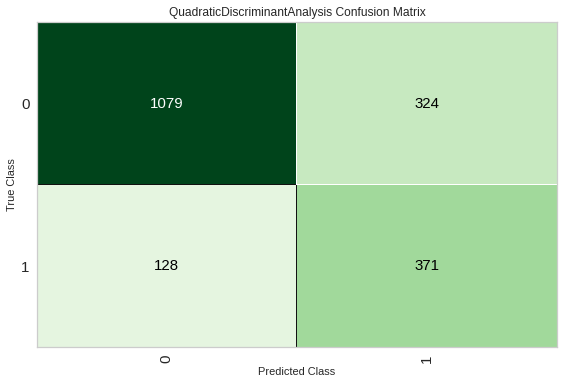

In [34]:
plot_model(base_model, plot="confusion_matrix")

It's possible to tune the base model and optmize a metric, for this case, F1 Score.



In [35]:
tuned_model = tune_model(base_model, fold=10, optimize="F1")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7512,0.8137,0.7627,0.5389,0.6316,0.4520,0.4675
1,0.7630,0.8264,0.7203,0.5592,0.6296,0.4594,0.4674
2,0.7701,0.8384,0.7373,0.5686,0.6421,0.4769,0.4856
3,0.7915,0.8458,0.7350,0.6014,0.6615,0.5130,0.5184
4,0.7464,0.8079,0.7009,0.5325,0.6052,0.4235,0.4322
5,0.7625,0.8441,0.7436,0.5541,0.6350,0.4645,0.4755
6,0.7506,0.8160,0.7607,0.5361,0.6290,0.4495,0.4651
7,0.7933,0.8466,0.7521,0.6027,0.6692,0.5216,0.5283
8,0.7553,0.8225,0.7179,0.5455,0.6199,0.4445,0.4536
9,0.7838,0.8426,0.7607,0.5855,0.6617,0.5068,0.5162


There's an improvement from the base model on F1 Score! Now, time to see what hyper-parameters were used by the tuned model.

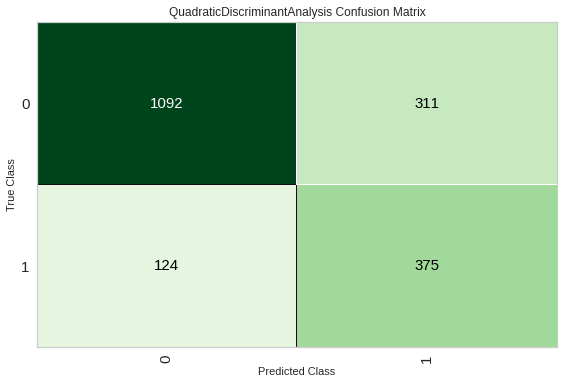

In [36]:
plot_model(tuned_model, plot="confusion_matrix")

In [37]:
bagged_model = ensemble_model(tuned_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7441,0.8130,0.7627,0.5294,0.6250,0.4402,0.4571
1,0.7630,0.8268,0.7203,0.5592,0.6296,0.4594,0.4674
2,0.7678,0.8384,0.7288,0.5658,0.6370,0.4703,0.4784
3,0.7891,0.8453,0.7350,0.5972,0.6590,0.5087,0.5144
4,0.7417,0.8072,0.6923,0.5260,0.5978,0.4127,0.4212
5,0.7625,0.8458,0.7436,0.5541,0.6350,0.4645,0.4755
6,0.7435,0.8180,0.7607,0.5266,0.6224,0.4377,0.4547
7,0.7910,0.8473,0.7521,0.5986,0.6667,0.5173,0.5244
8,0.7530,0.8236,0.7179,0.5419,0.6176,0.4404,0.4499
9,0.7791,0.8427,0.7607,0.5779,0.6568,0.4984,0.5086


In [38]:
blended_model = blend_models(estimator_list=[tuned_model, bagged_model], method="soft")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7464,0.8138,0.7627,0.5325,0.6272,0.4441,0.4606
1,0.7654,0.8268,0.7203,0.5629,0.6320,0.4636,0.4712
2,0.7749,0.8386,0.7373,0.5762,0.6468,0.4852,0.4932
3,0.7915,0.8458,0.7350,0.6014,0.6615,0.5130,0.5184
4,0.7417,0.8077,0.6923,0.5260,0.5978,0.4127,0.4212
5,0.7625,0.8454,0.7436,0.5541,0.6350,0.4645,0.4755
6,0.7458,0.8167,0.7521,0.5301,0.6219,0.4390,0.4543
7,0.7933,0.8471,0.7521,0.6027,0.6692,0.5216,0.5283
8,0.7553,0.8227,0.7179,0.5455,0.6199,0.4445,0.4536
9,0.7815,0.8426,0.7607,0.5817,0.6593,0.5026,0.5124


In [26]:
stacked_model = stack_models([tuned_model, bagged_model], method="auto")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7583,0.8188,0.5339,0.5727,0.5526,0.3873,0.3878
1,0.7773,0.8439,0.4915,0.6304,0.5524,0.4071,0.4127
2,0.7844,0.8394,0.5169,0.6421,0.5728,0.4308,0.4353
3,0.7938,0.8422,0.5128,0.6667,0.5797,0.4462,0.4529
4,0.7867,0.8202,0.5641,0.6286,0.5946,0.4505,0.4517
5,0.8052,0.8587,0.5726,0.6768,0.6204,0.4906,0.4937
6,0.7910,0.8370,0.5812,0.6355,0.6071,0.4651,0.4660
7,0.8314,0.8639,0.5812,0.7556,0.6570,0.5477,0.5560
8,0.7886,0.8303,0.5128,0.6522,0.5742,0.4362,0.4418
9,0.7933,0.8501,0.5385,0.6562,0.5915,0.4550,0.4590


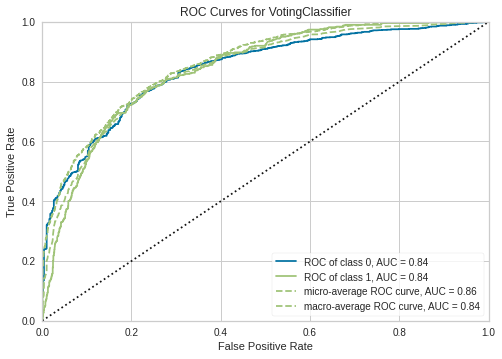

In [27]:
best_model = blended_model
plot_model(best_model, plot="auc")

In [28]:
predict_model(best_model);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7702,0.8415,0.7535,0.5449,0.6325,0.4716,0.4847


In [29]:
final_model = finalize_model(best_model)

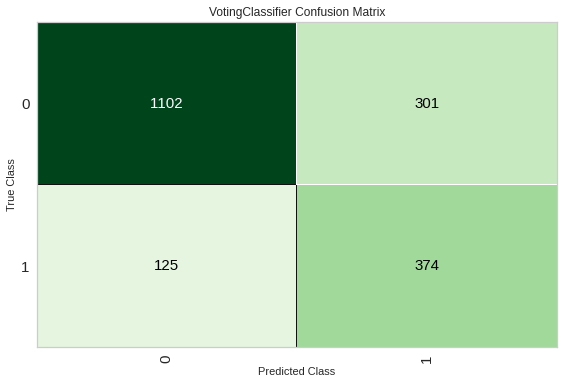

In [33]:
plot_model(final_model, plot = 'confusion_matrix')